In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
# Loading dataset
data = pd.read_csv('solar_radiation.csv')

In [4]:
# Convert month to numeric values
month_mapping = {month: idx for idx, month in enumerate(
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
}
data['month'] = data['month'].map(month_mapping)

In [5]:
print(data['month'].unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [6]:
data.head(15)

,year,month,H(h)_m,H(i_opt)_m,H(i)_m,Hb(n)_m,Kd,T2m
0,2005,0,119.84,180.85,193.17,183.94,0.27,13.9
1,2005,1,129.08,170.90,176.03,167.33,0.27,16.2
2,2005,2,177.04,202.98,199.13,208.03,0.26,23.1
3,2005,3,214.36,216.45,201.32,242.73,0.22,28.7
4,2005,4,231.14,208.67,184.48,247.26,0.22,32.2
5,2005,5,196.80,170.87,148.69,189.24,0.29,34.2
6,2005,6,149.06,134.66,120.24,117.22,0.41,28.8
7,2005,7,175.68,170.42,156.62,162.63,0.33,30.2
8,2005,8,139.82,150.98,145.31,137.84,0.34,27.8
9,2005,9,166.18,212.96,216.64,224.42,0.21,24.6


In [7]:
features = ['H(h)_m', 'H(i_opt)_m', 'H(i)_m', 'Hb(n)_m', 'Kd', 'T2m']
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

In [8]:
data.head(15)

,year,month,H(h)_m,H(i_opt)_m,H(i)_m,Hb(n)_m,Kd,T2m
0,2005,0,0.095537,0.606233,0.740586,0.624011,0.184211,0.072034
1,2005,1,0.167132,0.526728,0.608333,0.539227,0.184211,0.169492
2,2005,2,0.538742,0.783060,0.786574,0.746976,0.157895,0.461864
3,2005,3,0.827909,0.890691,0.803472,0.924098,0.052632,0.699153
4,2005,4,0.957927,0.828526,0.673534,0.947221,0.052632,0.847458
5,2005,5,0.691849,0.526488,0.397377,0.651064,0.236842,0.932203
6,2005,6,0.321943,0.237155,0.177855,0.283446,0.552632,0.703390
7,2005,7,0.528204,0.522893,0.458565,0.515237,0.342105,0.762712
8,2005,8,0.250349,0.367559,0.371296,0.388699,0.368421,0.661017
9,2005,9,0.454595,0.862805,0.921682,0.830637,0.026316,0.525424


In [9]:
#Taking Target variable in y And inputs in X
X = data[['H(h)_m', 'H(i_opt)_m', 'H(i)_m', 'Hb(n)_m', 'Kd', 'T2m', 'month']]
y = data['H(h)_m']

In [10]:
# Split data into training and testing sets -> 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LayerNormalization, MultiHeadAttention, Dropout, Flatten, Concatenate, Reshape, GlobalAveragePooling1D
from tensorflow.keras.models import Model

In [12]:
def build_transformer_model(input_shape):
    # Define inputs
    feature_inputs = Input(shape=input_shape, name='features')
    month_inputs = Input(shape=(1,), dtype='int32', name='month')
    
    # Embedding layer for month
    month_embedding = Embedding(input_dim=12, output_dim=8)(month_inputs)
    
    # Flatten the month embedding to be concatenated
    month_embedding = Flatten()(month_embedding)
    
    # Combine numerical features with month embeddings
    x = Concatenate()([feature_inputs, month_embedding])
    
    # Adding a transformer-like block
    x = Dense(128, activation='relu')(x)
    x = LayerNormalization()(x)
    x = Reshape((1, -1))(x)  # Reshape for MultiHeadAttention
    
    attention_output = MultiHeadAttention(
        num_heads=8,
        key_dim=64
    )(query=x, value=x, key=x)  # Using query, key, and value as x
    x = Dropout(0.1)(attention_output)
    x = Dense(64, activation='relu')(x)
    x = GlobalAveragePooling1D()(x)  # Ensure x is 3D for this layer
    x = Dense(1)(x)
    
    model = Model(inputs=[feature_inputs, month_inputs], outputs=x)
    model.compile(optimizer='adam', loss='mse')
    
    return model


In [13]:
input_shape = (X_train.shape[1] - 1, )  # Exclude month column
model = build_transformer_model(input_shape)   
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10)
]

# Ensure the month column in X_train and X_test are of integer type
X_train['month'] = X_train['month'].astype(np.int32)
X_test['month'] = X_test['month'].astype(np.int32)

history = model.fit(
    [X_train.drop(columns='month'), X_train['month']],
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks
)                        
test_loss = model.evaluate([X_test.drop(columns='month'), X_test['month']], y_test)
print(f'Test Loss: {test_loss}')

Epoch 1/50


/Users/apple/Desktop/sample_project/env/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.4449 - val_loss: 0.1430 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0983 - val_loss: 0.0262 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0372 - val_loss: 0.0098 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0273 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0132 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 6/50


/Users/apple/Desktop/sample_project/env/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0111 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0088 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - val_loss: 8.0247e-04 - learning_rate: 0.0010
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0047 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

In [14]:
predictions = model.predict([X_test.drop(columns='month'), X_test['month']]) 
y_pred = model.predict([X_test.drop(columns='month'), X_test['month']])
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred.flatten()
})

print(results.head())       

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
       Actual  Predicted
45   0.405780   0.400357
136  0.874167   0.887511
76   0.911049   0.911064
143  0.079575   0.087423
113  0.756625   0.735063


/Users/apple/Desktop/sample_project/env/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/Users/apple/Desktop/sample_project/env/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Mean Absolute Error: 0.016403207471342662
R-squared: 0.9932255175877762


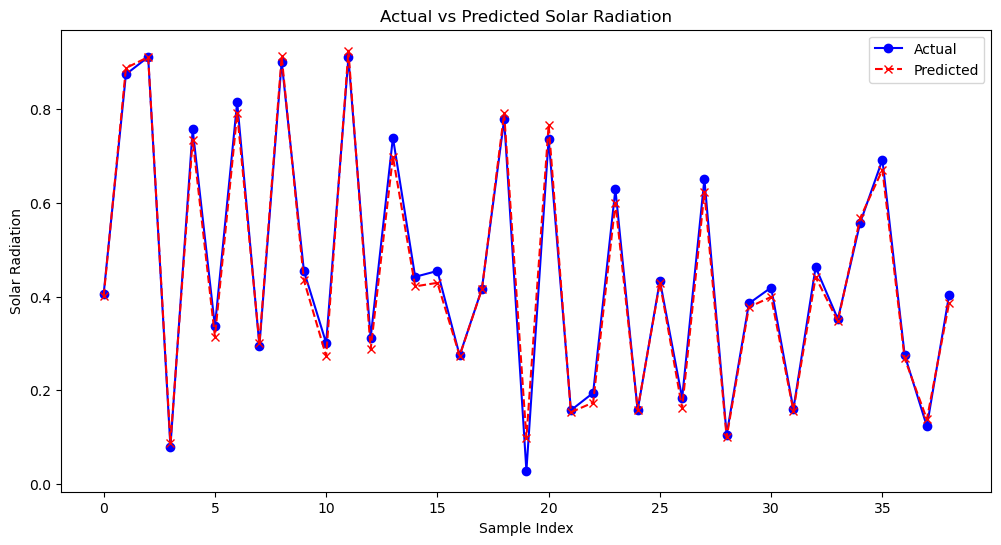

In [16]:
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")      
import matplotlib.pyplot as plt

# Plotting Actual vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='blue', linestyle='-', marker='o')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Solar Radiation')
plt.title('Actual vs Predicted Solar Radiation')
plt.legend()
plt.show()